In [1]:
%cd /kaggle/working/
!git clone -b kaggle  https://github.com/longtylata/Time-Series-Library.git

/kaggle/working
Cloning into 'Time-Series-Library'...
remote: Enumerating objects: 1680, done.
remote: Counting objects: 100% (792/792), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 1680 (delta 692), reused 656 (delta 638), pack-reused 888
Receiving objects: 100% (1680/1680), 78.26 MiB | 35.68 MiB/s, done.
Resolving deltas: 100% (1172/1172), done.


In [ ]:
%cd /kaggle/working/Time-Series-Library 
!python compair_kan_mlp.py -e 50001 -a none

In [3]:
%ls /kaggle/working/Time-Series-Library 


Function_Interpolation_Test.ipynb  plot_compair.py
LICENSE                            requirements.txt
README.md                          result_anomaly_detection.txt
compair_kan_mlp.py                 run.py
data_provider/                     scripts/
doc.txt                            transform_data.py
exp/                               transform_data.sh
layers/                            tutorial/
models/                            utils/
pic/


In [1]:
%cd /kaggle/working/Time-Series-Library 


/kaggle/working/Time-Series-Library


In [19]:

import argparse
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
# from kanKANLayer import kanKANLayer
from layers.kan_feedforward import KANLinear

# Define the fractal-like 2D function
def fractal_function(x, y):
    z = np.sin(10 * np.pi * x) * np.cos(10 * np.pi * y) + np.sin(np.pi * (x**2 + y**2))
    z += np.abs(x - y) + (np.sin(5 * x * y) / (0.1 + np.abs(x + y)))
    z *= np.exp(-0.1 * (x**2 + y**2))
    
    # Add noise to z
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    
    return z

# Define MLP and ChebyKAN
class SimpleMLP(nn.Module):
    def __init__(self, dim1=1024, dim2=512):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, dim1),
            nn.ReLU(),
            nn.Linear(dim1, dim2),
            nn.ReLU(),
            nn.Linear(dim2, 1)
        )
    
    def forward(self, x):
        return self.layers(x)


class FeedForward(nn.Module):
    def __init__(self, d_ff, activation='gelu'):
        super(FeedForward, self).__init__()
        self.linear1 = KANLinear(2, d_ff)
        self.linear2 = KANLinear(d_ff, 1)
        if activation == 'gelu':
            self.act = torch.nn.GELU()
        elif activation == 'relu':
            self.act = torch.nn.ReLU()
        else:
            self.act = torch.nn.Identity()
    def forward(self, x):
        x = self.linear1(x)
        x = self.act(x)
        return self.linear2(x)

def argument_parses():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '-e', '--epochs', default=20001, type=int
    )
    parser.add_argument(
        '-a', '--activation', default=None
    )
    args = parser.parse_args()
    return args

# if __name__ == '__main__': 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Generate sample data
# Generate 2D sample data
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = fractal_function(X, Y)
x_train_2d = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
y_train_2d = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1)

x_train = x_train_2d.to(device)
y_train = y_train_2d.to(device)

# args = argument_parses()
activation = 'gelu'
print("Activation: ", activation)
# Instantiate models
kan_model_16 =  FeedForward(16, activation=activation).to(device)
kan_model_24 = FeedForward(24, activation=activation).to(device)
kan_model_48 = FeedForward(48, activation=activation).to(device)

mlp_model_256 = SimpleMLP(dim1=256, dim2=128).to(device)
mlp_model_512 = SimpleMLP(dim1=512, dim2=256).to(device)
mlp_model_1024 = SimpleMLP(dim1=1024, dim2=512).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_kan_16 = torch.optim.Adam(kan_model_16.parameters(), lr=0.03)
optimizer_kan_24 = torch.optim.Adam(kan_model_24.parameters(), lr=0.03)
optimizer_kan_48 = torch.optim.Adam(kan_model_48.parameters(), lr=0.03)

optimizer_mlp_256 = torch.optim.Adam(mlp_model_256.parameters(), lr=0.01)
optimizer_mlp_512 = torch.optim.Adam(mlp_model_512.parameters(), lr=0.01)
optimizer_mlp_1024 = torch.optim.Adam(mlp_model_1024.parameters(), lr=0.01)

kan_16_losses = []
kan_24_losses = []
kan_48_losses = []


mlp_256_losses = []
mlp_512_losses = []
mlp_1024_losses = []


# Train the models
epochs = 3001
for epoch in range(epochs):
    optimizer_kan_16.zero_grad()
    outputs_kan_16 = kan_model_16(x_train)
    loss_kan_16 = criterion(outputs_kan_16, y_train)
    loss_kan_16.backward()
    optimizer_kan_16.step()

    optimizer_kan_24.zero_grad()
    outputs_kan_24 = kan_model_24(x_train)
    loss_kan_24 = criterion(outputs_kan_24, y_train)
    loss_kan_24.backward()
    optimizer_kan_24.step()

    optimizer_kan_48.zero_grad()
    outputs_kan_48 = kan_model_48(x_train)
    loss_kan_48 = criterion(outputs_kan_48, y_train)
    loss_kan_48.backward()
    optimizer_kan_48.step()


    optimizer_mlp_256.zero_grad()
    outputs_mlp_256 = mlp_model_256(x_train)
    loss_mlp_256 = criterion(outputs_mlp_256, y_train)
    loss_mlp_256.backward()
    optimizer_mlp_256.step()

    optimizer_mlp_512.zero_grad()
    outputs_mlp_512 = mlp_model_512(x_train)
    loss_mlp_512 = criterion(outputs_mlp_512, y_train)
    loss_mlp_512.backward()
    optimizer_mlp_512.step()

    optimizer_mlp_1024.zero_grad()
    outputs_mlp_1024 = mlp_model_1024(x_train)
    loss_mlp_1024 = criterion(outputs_mlp_1024, y_train)
    loss_mlp_1024.backward()
    optimizer_mlp_1024.step()

    if epoch % 100 == 0:
        kan_16_losses.append(loss_kan_16.item())
        kan_48_losses.append(loss_kan_48.item())
        kan_24_losses.append(loss_kan_24.item())

        mlp_256_losses.append(loss_mlp_256.item())
        mlp_512_losses.append(loss_mlp_512.item())
        mlp_1024_losses.append(loss_mlp_1024.item())

        print('Epoch {}/{}:\n\
                \tKAN(16) Loss: {},\n\
                \tKAN(24) Loss: {},\n\
                \tKAN(48) Loss: {},\n\
                \tMLP(256) Loss: {},\n\
                \tMLP(512) Loss: {}, \n\
                \tMLP(1024) Loss: {}'.format(
                    epoch+1, epochs,
                    loss_kan_16,
                    loss_kan_24,
                    loss_kan_48,
                    loss_mlp_256,
                    loss_mlp_512,
                    loss_mlp_1024
            ))


# Test the models
x_test = np.linspace(0, 2, 400)
y_test = np.linspace(0, 2, 400)
X_test, Y_test = np.meshgrid(x_test, y_test)
Z_test = fractal_function(X_test, Y_test)
x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32).to(device)

y_pred_kan_16 = kan_model_16(x_test_2d).detach().cpu().numpy()
y_pred_kan_24 = kan_model_24(x_test_2d).detach().cpu().numpy()
y_pred_kan_48 = kan_model_48(x_test_2d).detach().cpu().numpy()

y_pred_mlp_256 = mlp_model_256(x_test_2d).detach().cpu().numpy()
y_pred_mlp_512 = mlp_model_512(x_test_2d).detach().cpu().numpy()
y_pred_mlp_1024 = mlp_model_1024(x_test_2d).detach().cpu().numpy()




Activation:  gelu
Epoch 1/3001:
                	KAN(16) Loss: 1.1140893697738647,
                	KAN(24) Loss: 1.2645258903503418,
                	KAN(48) Loss: 1.2738460302352905,
                	MLP(256) Loss: 0.9931628704071045,
                	MLP(512) Loss: 1.3380489349365234, 
                	MLP(1024) Loss: 1.2965571880340576
Epoch 101/3001:
                	KAN(16) Loss: 0.2255023866891861,
                	KAN(24) Loss: 0.24240395426750183,
                	KAN(48) Loss: 0.2017267793416977,
                	MLP(256) Loss: 0.3488908112049103,
                	MLP(512) Loss: 0.36823365092277527, 
                	MLP(1024) Loss: 0.39236322045326233
Epoch 201/3001:
                	KAN(16) Loss: 0.19518639147281647,
                	KAN(24) Loss: 0.1843707412481308,
                	KAN(48) Loss: 0.17209608852863312,
                	MLP(256) Loss: 0.26338645815849304,
                	MLP(512) Loss: 0.2812027633190155, 
                	MLP(1024) Loss: 0.3237854838371277


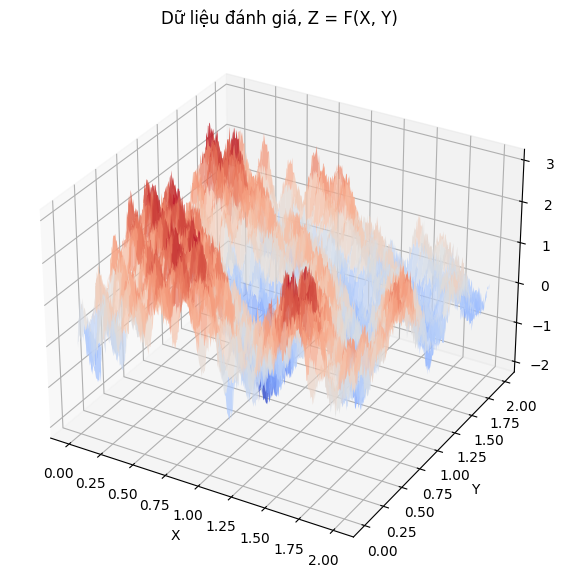

In [7]:
# Plot the results using a 3D plot

# Test the models
x_test = np.linspace(0, 2, 400)
y_test = np.linspace(0, 2, 400)
X_test, Y_test = np.meshgrid(x_test, y_test)
Z_test = fractal_function(X_test, Y_test)
x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32).to(device)
fig = plt.figure(figsize=(7, 7))

ax0 = fig.add_subplot(1,1,1, projection='3d')
ax0.plot_surface(X_test, Y_test, Z_test, cmap='coolwarm', alpha=0.7, label='Original Function')
ax0.set_title('Dữ liệu đánh giá, Z = F(X, Y)')
ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_zlabel('Z')
plt.savefig('OrgData.png')


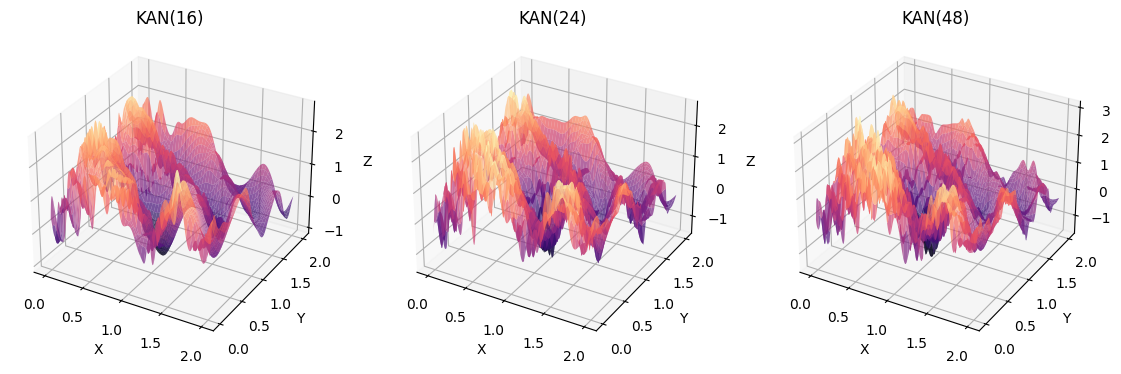

In [21]:
    fig = plt.figure(figsize=(14, 21))
    ax2 = fig.add_subplot(131, projection='3d')
    ax2.plot_surface(X_test, Y_test, y_pred_kan_16.reshape(X_test.shape), cmap='magma', alpha=0.7, label='KAN(16)')
    ax2.set_title('KAN(16)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    ax2_1 = fig.add_subplot(132, projection='3d')
    ax2_1.plot_surface(X_test, Y_test, y_pred_kan_24.reshape(X_test.shape), cmap='magma', alpha=0.7, label='KAN(24)')
    ax2_1.set_title('KAN(24)')
    ax2_1.set_xlabel('X')
    ax2_1.set_ylabel('Y')
    ax2_1.set_zlabel('Z')

    ax2_2 = fig.add_subplot(133, projection='3d')
    ax2_2.plot_surface(X_test, Y_test, y_pred_kan_48.reshape(X_test.shape), cmap='magma', alpha=0.7, label='KAN(48)')
    ax2_2.set_title('KAN(48)')
    ax2_2.set_xlabel('X')
    ax2_2.set_ylabel('Y')
    ax2_2.set_zlabel('Z')
    plt.savefig('KANData.png')



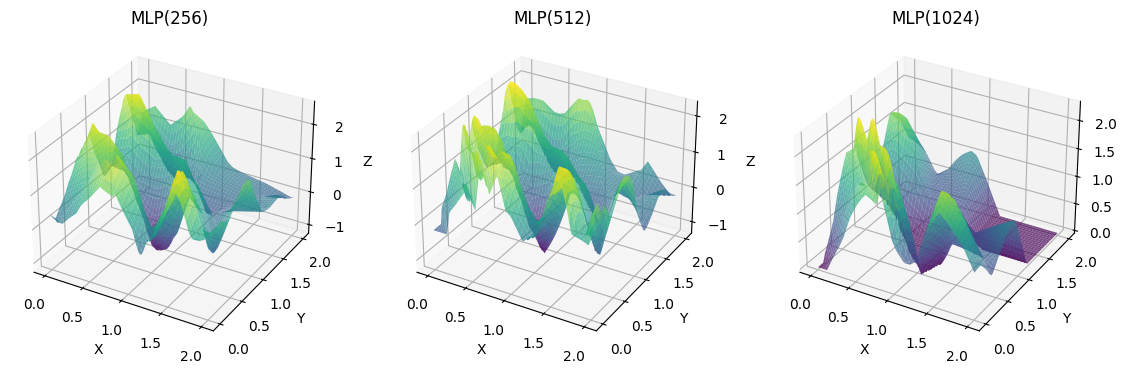

In [23]:

    fig = plt.figure(figsize=(14, 21))
    ax3 = fig.add_subplot(131, projection='3d')
    ax3.plot_surface(X_test, Y_test, y_pred_mlp_256.reshape(X_test.shape), cmap='viridis', alpha=0.7, label='MLP(256)')
    ax3.set_title('MLP(256)')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    ax3_1 = fig.add_subplot(132, projection='3d')
    ax3_1.plot_surface(X_test, Y_test, y_pred_mlp_512.reshape(X_test.shape), cmap='viridis', alpha=0.7, label='MLP(512)')
    ax3_1.set_title('MLP(512)')
    ax3_1.set_xlabel('X')
    ax3_1.set_ylabel('Y')
    ax3_1.set_zlabel('Z')

    ax3_2 = fig.add_subplot(133, projection='3d')
    ax3_2.plot_surface(X_test, Y_test, y_pred_mlp_1024.reshape(X_test.shape), cmap='viridis', alpha=0.7, label='MLP(=1024)')
    ax3_2.set_title('MLP(1024)')
    ax3_2.set_xlabel('X')
    ax3_2.set_ylabel('Y')
    ax3_2.set_zlabel('Z')

    plt.savefig('MLP.png')

   


In [24]:
# outdata_df_train = {
#     'x_train': x_train.cpu().numpy().reshape(1, -1)[0].tolist(),
#     'y_train': y_train.cpu().numpy().reshape(1, -1)[0].tolist(),
# }
# outdata_df_train = pd.DataFrame(outdata_df_train, columns=outdata_df_train.keys())
# outdata_df_train.to_csv('train_data.csv', index=False)

# outdata_df_test = {
#     'x_test': x_test.cpu().numpy().reshape(1, -1)[0].tolist(),
#     'y_pred_kan_8': y_pred_kan_8.cpu().numpy().reshape(1, -1)[0].tolist(),
#     'y_pred_kan_16': y_pred_kan_16.cpu().numpy().reshape(1, -1)[0].tolist(),
#     'y_pred_kan_24': y_pred_kan_24.cpu().numpy().reshape(1, -1)[0].tolist(),
#     'y_pred_mlp_64': y_pred_mlp_64.cpu().numpy().reshape(1, -1)[0].tolist(),
#     'y_pred_mlp_128': y_pred_mlp_128.cpu().numpy().reshape(1, -1)[0].tolist(),
#     'y_pred_mlp_256': y_pred_mlp_256.cpu().numpy().reshape(1, -1)[0].tolist(),
# }
# outdata_df_test = pd.DataFrame(outdata_df_test, columns=outdata_df_test.keys())
# outdata_df_test.to_csv('test_data.csv', index=False)

outloss_df = {
    'kan_16_loss': kan_16_losses,#.cpu().numpy().tolist(),
    'kan_24_loss': kan_24_losses, #.cpu().numpy().tolist(),
    'kan_48_loss': kan_48_losses, #.cpu().numpy().tolist(),
    'mlp_256_loss': mlp_256_losses, #.cpu().numpy().tolist(),
    'mlp_512_loss': mlp_512_losses, #.cpu().numpy().tolist(),
    'mlp_1024_loss': mlp_1024_losses, #.cpu().numpy().tolist()
}

outloss_df = pd.DataFrame(outloss_df, columns=outloss_df.keys())
outloss_df.to_csv('loss_data.csv', index=False)

In [4]:
%cd /kaggle/working/Time-Series-Library
import argparse
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
# from kanKANLayer import kanKANLayer
from layers.kan_feedforward import KANLinear

# Define the fractal-like 2D function
def fractal_function(x, y):
    z = np.sin(10 * np.pi * x) * np.cos(10 * np.pi * y) + np.sin(np.pi * (x**2 + y**2))
    z += np.abs(x - y) + (np.sin(5 * x * y) / (0.1 + np.abs(x + y)))
    z *= np.exp(-0.1 * (x**2 + y**2))
    
    # Add noise to z
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    
    return z

# Define MLP and ChebyKAN
class SimpleMLP(nn.Module):
    def __init__(self, dim1=1024, dim2=512):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, dim1),
            nn.ReLU(),
            nn.Linear(dim1, dim2),
            nn.ReLU(),
            nn.Linear(dim2, 1)
        )
    
    def forward(self, x):
        return self.layers(x)


class FeedForward(nn.Module):
    def __init__(self, d_ff, activation='gelu'):
        super(FeedForward, self).__init__()
        self.linear1 = KANLinear(2, d_ff)
        self.linear2 = KANLinear(d_ff, 1)
        if activation == 'gelu':
            self.act = torch.nn.GELU()
        elif activation == 'relu':
            self.act = torch.nn.ReLU()
        else:
            self.act = torch.nn.Identity()
    def forward(self, x):
        x = self.linear1(x)
        x = self.act(x)
        return self.linear2(x)

def argument_parses():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '-e', '--epochs', default=20001, type=int
    )
    parser.add_argument(
        '-a', '--activation', default=None
    )
    args = parser.parse_args()
    return args

# if __name__ == '__main__': 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Generate sample data
# Generate 2D sample data
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = fractal_function(X, Y)

/kaggle/working/Time-Series-Library


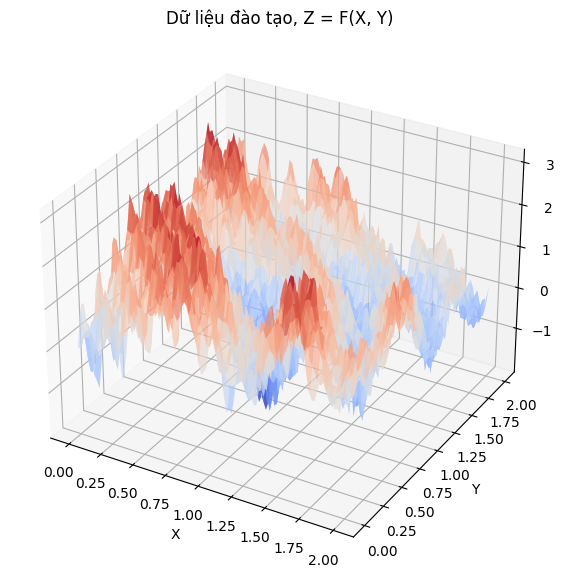

In [6]:
# Plot the results using a 3D plot
fig = plt.figure(figsize=(7, 7))

ax0 = fig.add_subplot(1,1,1, projection='3d')
ax0.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7, label='Original Function')
ax0.set_title('Dữ liệu đào tạo, Z = F(X, Y)')
ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_zlabel('Z')
plt.savefig('TrainData.png')
